In [3]:
import os
import numpy as np
import json
import math
from PyAstronomy import pyasl

an = pyasl.AtomicNo()


with open('output.json','r') as f:
    qm9=json.load(f)

In [4]:
qm9["1"]

{'symbol': 'CH4',
 'n_atoms': 5,
 'coordinates': [['C', -0.0126981359, 1.0858041578, 0.0080009958],
  ['H', 0.002150416, -0.0060313176, 0.0019761204],
  ['H', 1.0117308433, 1.4637511618, 0.0002765748],
  ['H', -0.540815069, 1.4475266138, -0.8766437152],
  ['H', -0.5238136345, 1.4379326443, 0.9063972942]],
 'energy_U0': [-1101.4877900833399]}

In [9]:
theta1=np.pi/2
phi1=np.pi/2
theta2=np.pi/6
phi2=np.pi/4

In [55]:
def calqubit(theta,phi):
    return np.array([np.cos(theta/2),np.sin(theta/2)*np.exp(1j*phi)])

In [41]:
from AtomLoader import *

In [42]:
t=np.array([1,2,0.5])
p=np.array([0.5,1,2])

In [44]:
with open('output.json','r') as f:
    qm9=json.load(f)
def Set_center(molecule, set_axis=False):
    cord=np.array(molecule["coordinates"])[:,1:].astype(float)
    atomic_num=np.zeros(len(cord[:,0]))
    for i in range(len(cord[:,0])): #원자 개수 n
        atomic_num[i]=an.getAtomicNo(molecule["coordinates"][i][0])
    distance_martix=np.sqrt(np.sum(np.power(cord[np.newaxis,:,:]-cord[:,np.newaxis,:],2),axis=2))
    # (n,n)  
    bloch_cord=(cord[:,np.newaxis,:]-cord[np.newaxis,:,:]+epsilon)/(distance_martix[:,:,np.newaxis]+epsilon) # n,n,3 
    if set_axis==False:
        return bloch_cord, distance_martix, atomic_num, molecule['energy_U0']
    # (n,n,3)
    elif set_axis==True: ##가장 가까운 원자를 z축 위에, 두번쨰로 가짜운 원자는 xz 평면 위에 올리기(rotation sym 맞추려고 강제)
        bloch_theta=np.arccos(bloch_cord[:,:,2])
        # (n,n)
        bloch_pi=np.arctan2(bloch_cord[:,:,1],bloch_cord[:,:,0])
        # (n,n)
        min_point=np.argsort(distance_martix,axis=1)[:,:3]

        theta1=np.array([bloch_theta[i,x] for i,x in enumerate(min_point[:,1])])
        theta2=np.array([bloch_theta[i,x] for i,x in enumerate(min_point[:,2])])
        pi1=np.array([bloch_pi[i,x] for i,x in enumerate(min_point[:,1])])
        pi2=np.array([bloch_pi[i,x] for i,x in enumerate(min_point[:,2])])
        pi_prime=np.arctan2(np.sin(theta2)*np.sin(pi2-pi1),np.cos(theta1)*np.sin(theta2)*np.cos(pi2-pi1)-np.sin(theta1)*np.cos(theta2))
        rot3=rotation_matrix('z',-pi_prime[:,np.newaxis])
        rot2=rotation_matrix('y',(-theta1)[:,np.newaxis])
        rot1=rotation_matrix('z',(-pi1)[:,np.newaxis])
        sym_bloch_cord=np.einsum('abij,abjk,abkl,abl-> abi',rot3,rot2,rot1,bloch_cord)
        sym_bloch_cord[(np.abs(sym_bloch_cord)<epsilon)]=0
        for i in range(len(sym_bloch_cord[:,0,0])):
            sym_bloch_cord[i,i,:]=0
        return sym_bloch_cord, distance_martix, atomic_num, molecule['energy_U0']

In [2]:
qm9["1"]

NameError: name 'qm9' is not defined

In [142]:
sym_bloch_cord, distance_martix, atomic_num, energy=Set_center(q,True)

In [206]:
para=np.array([[0,0.5],
               [0.1,1],
               [0.3,2]])

In [207]:
def Cutoff_function(distance, cutoff_radius=5):
    return 0.5*(np.cos(math.pi*distance/cutoff_radius)+1)

def calqubit(theta,phi):
    return np.stack((np.cos(theta/2),np.sin(theta/2)*np.exp(1j*phi)),axis=-1)

def returnangle(qubit):
    the=2*np.arctan2(np.abs(qubit[:,:,1]),np.real(qubit[:,:,0]))
    ph=np.arctan2(qubit[:,:,1].imag,qubit[:,:,1].real)
    return(np.stack((the,ph),axis=2))
    

def Cal_descriptor(cord,distance_matrix,classic=False,parameter=None,descript_parameter=None, weigthed=False, atomic_num=None, cutoff_radius=5, halve=False):
    if classic==True:
        descriptor=calqubit(np.arccos(cord[:,:,2]),np.arctan2(cord[:,:,1],cord[:,:,0]))*Cutoff_function(distance_matrix[:,:,np.newaxis],cutoff_radius=cutoff_radius)
        descriptor=descriptor[:,np.newaxis,:,:]*np.exp(-descript_parameter[np.newaxis,:,np.newaxis,np.newaxis,0]*np.power(distance_matrix[:,np.newaxis,:,np.newaxis]-descript_parameter[np.newaxis,:,np.newaxis,np.newaxis,1],2))
        if weigthed==True:
            atomic_weight=np.zeros((len(atomic_num),len(atomic_num)))
            for i in range(len(atomic_num)):
                for j in range(len(atomic_num)):
                    atomic_weight[i,j]=atomic_num[i]*atomic_num[j]
            descriptor=descriptor*atomic_weight[:,np.newaxis,:,np.newaxis]
    else:
        descriptor=calqubit(np.arccos(cord[:,:,2]),np.arctan2(cord[:,:,1],cord[:,:,0]))
        descriptor=descriptor[:,np.newaxis,:,:]*parameter[np.newaxis,:,np.newaxis,np.newaxis]
    descriptor=np.sum(descriptor,axis=2)
    descript_size=np.sqrt(np.sum(descriptor*descriptor.conj(),axis=2))
    descriptor=descriptor/descript_size[:,:,np.newaxis]
    
    
    
    return returnangle(descriptor),descript_size

In [209]:
des,dessize=Cal_descriptor(sym_bloch_cord, distance_martix,classic=True,descript_parameter=para)

In [210]:
des.shape

(13, 3, 2)

In [1]:
para

NameError: name 'para' is not defined

In [6]:
loss=np.array([[22621.94988035],
 [ 4251.92234518],
 [ 1965.63880769],
 [ 1428.491095  ],
 [ 1262.96980779],
 [ 1010.95506928],
 [  622.14008082],
 [ 1127.38961069],
 [  707.32846518],
 [  499.98213771],
 [  349.09720823],
 [  596.38339652],
 [  579.47065846],
 [  618.83695642],
 [  346.33447331],
 [  366.65215697],
 [  639.21851439],
 [  373.9518873 ],
 [  466.1205681 ],
 [  525.17752287],
 [  520.86017381],
 [  337.37089432],
 [  566.13677738],
 [  466.19492523],
 [  312.4006113 ],
 [  359.17791618],
 [  316.40693461],
 [  339.9544072 ],
 [  391.85964933],
 [  409.96124171],
 [  333.67129082],
 [  336.78900385],
 [  294.18401405],
 [  466.80808769],
 [  548.73644418],
 [  420.31165328],
 [  431.3941526 ],
 [  291.85485812],
 [  224.21601232],
 [  311.25002636],
 [  412.00508145],
 [  280.47647361],
 [  212.89450689],
 [  239.76476132],
 [  311.74171296],
 [  300.08934922],
 [  373.82232943],
 [  204.85616611],
 [  227.56221441],
 [  237.33569447],
 [  216.36572532],
 [  269.91294406],
 [  189.63978275],
 [  398.74419565],
 [  196.00115845],
 [  495.02680228],
 [  217.82992829],
 [  269.64209658],
 [  225.60099248],
 [  318.03959739],
 [  170.70261514],
 [  284.34973213],
 [  243.65227588],
 [  286.5606653 ],
 [  345.25945102],
 [  290.0833657 ],
 [  233.29038722],
 [  278.78487074],
 [  355.01927391],
 [  261.70243842],
 [  240.15725959],
 [  176.23823926],
 [  232.93839517],
 [  245.18912581],
 [  173.98384811],
 [  349.25868615],
 [  299.77570464],
 [  210.85687416],
 [  283.07176679],
 [  155.52140211],
 [  268.08898795],
 [  196.52491067],
 [  290.49481859],
 [  243.18219485],
 [  315.41216146],
 [  210.74493913],
 [  248.03099059],
 [  250.40496128],
 [  149.54827192],
 [  204.40411737],
 [  204.13530238],
 [  219.39012549],
 [  125.37305228],
 [  253.4603462 ],
 [  204.82661401],
 [  227.54788616],
 [  223.93661141],
 [  217.19967201],
 [  260.26067066],
 [  193.85966706]])

In [10]:
loss=loss[:,0]

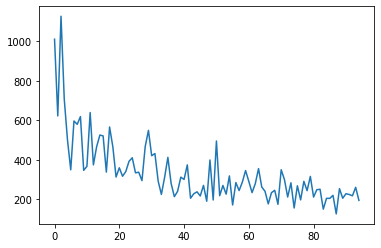

In [14]:
import matplotlib.pyplot as plt

plt.plot(loss[5:])

In [15]:
import multiprocessing as mp
mp.cpu_count()

16

In [ ]:
[-0.10427488  0.39103157  2.00803408 -1.03417637 -0.3711771   0.11335513
  1.31828257  3.19598659 -0.25595048 -1.06790523  0.05467634 -0.09911154
  0.63642456 -1.25679513  1.39696794  1.14624053 -0.02484633  0.15336306
  0.22153725 -0.09010125 -0.16219164 -1.54976815  0.03012084 -0.03090227]

[[1.86165939e+01 7.58334429e-01]
 [9.84366970e+00 7.72104692e+00]
 [7.68903392e+00 8.53899444e-04]
 [5.21409959e+00 9.53466509e+00]
 [1.20117567e+01 2.71973547e+00]
 [7.62945243e+00 3.99941299e-04]]

In [ ]:
[-2.72381803e-02 -8.76446844e-02  5.85174249e-02  5.81141991e-02
 -1.34082530e+00  4.77398103e-01  3.82739910e+00 -5.62684470e+00
 -1.76862730e-01 -5.03979696e-01  3.09392131e-01 -9.68527281e-02
 -1.79331289e+00 -3.75747175e-03  2.87347149e+00  1.04095908e+00
 -8.73850184e-02  5.17992110e-01  3.60659010e+00  3.37353967e-01
  2.03054936e-01 -1.87556620e-01 -5.12462708e-01 -4.87809436e-01]
[[1.02126836e+01 2.74705206e+00]
 [8.71367535e+00 7.77495470e+00]
 [6.92658799e+00 3.52060165e-03]
 [5.99408910e+00 9.53860202e+00]
 [1.62510271e+01 7.78600562e-01]
 [7.41957673e+00 2.10923351e-03]]


In [ ]:
[ -0.47594351  -4.50743477  -8.46613537  -0.19065087  -1.1726193
 -11.25678421  14.01949377  -8.60061223  -0.25404365   0.23194815
   0.10643894   0.74158512]

[[7.44546256e+00 3.58156079e-04]
 [1.61157272e+01 7.72828926e-01]
 [5.79686532e+00 8.85346477e+00]]

In [1]:
[i for i in range(5)]

[0, 1, 2, 3, 4]